# Statistical comparison of genetic variant frequencies: In-house vs ALFA database

This analysis aimed to statistically compare the frequencies of variant alleles derived from in-house African genetic data to that of data obtained from the [NCBI ALFA database](https://www.ncbi.nlm.nih.gov/snp/docs/gsr/alfa/) for African, European and Asian populations using a two-tailed Fisher's Exact Test. 

To achieve this, the following steps were performed: 

1. In-house Data Generation: In-house genetic variant allele count data was generated from genetic information obtained from the [GnomAD 1000 Genomes and HGDP datasets](https://gnomad.broadinstitute.org/news/2021-10-gnomad-v3-1-2-minor-release/) for African population. This data was prepared for analysis by following the steps outlined in the `Notebooks\Data_preparation\2-IH_allele_counts.ipynb` Jupyter notebook. The prepared data is stored in `Data\Processed\IH_allele_counts_fishers.csv` and `Data\Processed\IH_allele_counts.csv`.
2. ALFA Data Retrieval: Variant allele count data for variants with rsIDs was retrieved from the NCBI ALFA database. This data was prepared for analysis by following the steps outlined in the  `Notebooks\Data_preparation\3-ALFA_allele_counts_a.ipynb` and `Notebooks\Data_preparation\3-ALFA_allele_counts_b.ipynb` notebooks. The prepared data is stored in `Data\Processed\ALFA_allele_counts_b.csv`
3. Data Integration: The variant allele count data generated in-house and the data fetched from ALFA were combined into a unified dataframe for analysis.
4. Data Filtering: The data was filtered to encompass only the data for specific population groups including the ALFA African Others, EUR, EAS, SAS populations, as well as the averaged Recent African population.
5. Fisher's Exact Tests: Two-tailed Fisher's Exact Tests were conducted to test for significant differences in variant allele frequencies among the selected population groups. Additionally, to account for multiple comparisons, the Bonferroni method was employed to correct the Fisher's test results.
6. Data Visualisation: The number of variants with significant differences for each comparison population group were plotted.

## Imports

Notebook setup

In [1]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import itertools
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import json
import seaborn as sns
from matplotlib import pyplot as plt
from upsetplot import plot
from requests import get, codes as http_code
from warnings import simplefilter
import Utils.constants as constants
import Utils.functions as functions

Import in-house variant allele count data

In [2]:
ih_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts_fishers.csv",
    )
).drop(columns="Unnamed: 0")

ih_data.head(5)

,VAR_NAME,ID,REF,ALT,GENE,POS,ALT_CT_IH_ACB,ALT_CT_IH_ASW,ALT_CT_IH_African,ALT_CT_IH_CA,...,ALT_CT_IH_SA,ALT_CT_IH_WA,CORR_REF_CT_IH_ACB,CORR_REF_CT_IH_ASW,CORR_REF_CT_IH_African,CORR_REF_CT_IH_CA,CORR_REF_CT_IH_EA,CORR_REF_CT_IH_Recent African,CORR_REF_CT_IH_SA,CORR_REF_CT_IH_WA
0,chr11:34438836T-C,34438836_C_T,T,C,CAT,34438836,0,0,1,0,...,0,0,228,142,1977,80,217,1607,28,1282
1,chr11:34438889G-C,34438889_C_G,G,C,CAT,34438889,0,0,1,0,...,1,0,228,142,1977,80,218,1607,27,1282
2,chr11:34438910C-T,34438910_T_C,C,T,CAT,34438910,0,0,0,0,...,0,0,228,142,1978,80,218,1608,28,1282
3,chr11:34439179A-G,34439179_G_A,A,G,CAT,34439179,0,0,0,0,...,0,0,228,142,1978,80,218,1608,28,1282
4,chr11:34439188C-G,34439188_G_C,C,G,CAT,34439188,0,0,0,0,...,0,0,228,142,1978,80,218,1608,28,1282


Import ALFA variant allele count data

In [3]:
alfa_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "ALFA_allele_counts_b.csv",
    )
).drop(columns="Unnamed: 0")

alfa_data.head(5)

,variant_id,reference_allele,alternate_allele,ALT_CT_ALFA_African,ALT_CT_ALFA_African American,ALT_CT_ALFA_African Others,ALT_CT_ALFA_Asian,ALT_CT_ALFA_East Asian,ALT_CT_ALFA_European,ALT_CT_ALFA_Latin American 1,...,REF_CT_ALFA_African Others,REF_CT_ALFA_Asian,REF_CT_ALFA_East Asian,REF_CT_ALFA_European,REF_CT_ALFA_Latin American 1,REF_CT_ALFA_Latin American 2,REF_CT_ALFA_Other,REF_CT_ALFA_Other Asian,REF_CT_ALFA_South Asian,REF_CT_ALFA_Total
0,rs1000343,C,T,695.0,671.0,24.0,0.0,0.0,49.0,5.0,...,296.0,622.0,490.0,109377.0,673.0,2200.0,5457.0,132.0,184.0,127076.0
1,rs1000989,T,C,1435.0,1388.0,47.0,80.0,55.0,21489.0,123.0,...,135.0,158.0,109.0,37269.0,273.0,2052.0,1371.0,49.0,3283.0,48171.0
2,rs1000990,T,C,798.0,767.0,31.0,42.0,32.0,5355.0,40.0,...,83.0,70.0,54.0,8931.0,106.0,349.0,459.0,16.0,62.0,12125.0
3,rs1005573,C,T,3120.0,3009.0,111.0,63.0,35.0,10693.0,209.0,...,15.0,101.0,69.0,4955.0,87.0,956.0,474.0,32.0,31.0,7130.0
4,rs1007311,A,G,1970.0,1903.0,67.0,88.0,56.0,9154.0,61.0,...,55.0,80.0,56.0,11242.0,85.0,456.0,1538.0,24.0,55.0,15040.0


## Data integration

Filter in-house data for variants with rsIDs. ALFA data is only available for variants with rsIDs.

In [4]:
ih_data_rsids = ih_data[ih_data.VAR_NAME.str.contains("rs")]

Merge in-house and ALFA variant count data

In [5]:
ih_alfa_data = ih_data_rsids.merge(
    alfa_data,
    how="left",
    left_on=["VAR_NAME", "REF", "ALT"],
    right_on=["variant_id", "reference_allele", "alternate_allele"],
).drop(columns=["variant_id", "reference_allele", "alternate_allele"])

ih_alfa_data = ih_alfa_data.replace(np.NAN, 0)

ih_alfa_data.head(5)

,VAR_NAME,ID,REF,ALT,GENE,POS,ALT_CT_IH_ACB,ALT_CT_IH_ASW,ALT_CT_IH_African,ALT_CT_IH_CA,...,REF_CT_ALFA_African Others,REF_CT_ALFA_Asian,REF_CT_ALFA_East Asian,REF_CT_ALFA_European,REF_CT_ALFA_Latin American 1,REF_CT_ALFA_Latin American 2,REF_CT_ALFA_Other,REF_CT_ALFA_Other Asian,REF_CT_ALFA_South Asian,REF_CT_ALFA_Total
0,rs1000343,34452510_T_C,C,T,CAT,34452510,24,17,172,1,...,296.0,622.0,490.0,109377.0,673.0,2200.0,5457.0,132.0,184.0,127076.0
1,rs1000989,110174956_C_T,T,C,COL4A1,110174956,56,44,522,29,...,135.0,158.0,109.0,37269.0,273.0,2052.0,1371.0,49.0,3283.0,48171.0
2,rs1000990,110174971_C_T,T,C,COL4A1,110174971,56,44,519,29,...,83.0,70.0,54.0,8931.0,106.0,349.0,459.0,16.0,62.0,12125.0
3,rs1005573,33026408_T_C,C,T,OLIG2,33026408,204,118,1731,70,...,15.0,101.0,69.0,4955.0,87.0,956.0,474.0,32.0,31.0,7130.0
4,rs1007311,150998920_G_A,A,G,NOS3,150998920,145,88,1133,24,...,55.0,80.0,56.0,11242.0,85.0,456.0,1538.0,24.0,55.0,15040.0


## Data filtering
Filter the data to include only the specific comparison populations of interest. Retain the ALFA African Others, EUR, EAS, SAS populations, as well as the averaged Recent African population.

In [6]:
ih_alfa_comparisons = ih_alfa_data[
    [
        "ID",
        "VAR_NAME",
        "REF", 
        "ALT",
        "POS",
        "GENE",
        "ALT_CT_IH_Recent African",
        "CORR_REF_CT_IH_Recent African",
        "ALT_CT_ALFA_African Others",
        "REF_CT_ALFA_African Others",
        "ALT_CT_ALFA_East Asian",
        "REF_CT_ALFA_East Asian",
        "ALT_CT_ALFA_South Asian",
        "REF_CT_ALFA_South Asian",
        "ALT_CT_ALFA_European",
        "REF_CT_ALFA_European",
    ]
].rename(columns={"CORR_REF_CT_IH_Recent African": "REF_CT_IH_Recent African"})

ih_alfa_comparisons.tail(5)

,ID,VAR_NAME,REF,ALT,POS,GENE,ALT_CT_IH_Recent African,REF_CT_IH_Recent African,ALT_CT_ALFA_African Others,REF_CT_ALFA_African Others,ALT_CT_ALFA_East Asian,REF_CT_ALFA_East Asian,ALT_CT_ALFA_South Asian,REF_CT_ALFA_South Asian,ALT_CT_ALFA_European,REF_CT_ALFA_European
14929,110254294_C_T,rs9805608,T,C,110254294,COL4A1,206,1402,33.0,175.0,23.0,75.0,53.0,61.0,9552.0,21776.0
14930,48242167_A_G,rs9807869,G,A,48242167,CARD8,479,1129,30.0,84.0,1.0,85.0,0.0,98.0,16.0,9808.0
14931,110198689_C_T,rs995223,T,C,110198689,COL4A1,695,913,71.0,139.0,40.0,454.0,24.0,132.0,34291.0,96137.0
14932,110198495_G_A,rs995224,A,G,110198495,COL4A1,339,1269,10.0,80.0,3.0,101.0,1.0,59.0,8596.0,25474.0
14933,33027838_T_G,rs9982080,G,T,33027838,OLIG2,232,1376,13.0,101.0,10.0,76.0,9.0,89.0,1513.0,12773.0


Replace missing allele frequencies with 0

In [7]:
ih_alfa_comparisons = ih_alfa_comparisons.replace(np.NAN, 0)

Remove rows with frequencies of 0. We only want to include variants that are present in all comparison populations.

In [8]:
# Remove rows where population groups alt allele counts are 0. These rows contain variants that are not present in one of the populations.

ih_alfa_comparisons = ih_alfa_comparisons[
    (ih_alfa_comparisons["ALT_CT_IH_Recent African"] != 0)
    & (ih_alfa_comparisons["ALT_CT_ALFA_African Others"] != 0)
    & (ih_alfa_comparisons["ALT_CT_ALFA_East Asian"] != 0)
    & (ih_alfa_comparisons["ALT_CT_ALFA_South Asian"] != 0)
    & (ih_alfa_comparisons["ALT_CT_ALFA_European"] != 0)
]

In [9]:
ih_alfa_comparisons.head(5)

,ID,VAR_NAME,REF,ALT,POS,GENE,ALT_CT_IH_Recent African,REF_CT_IH_Recent African,ALT_CT_ALFA_African Others,REF_CT_ALFA_African Others,ALT_CT_ALFA_East Asian,REF_CT_ALFA_East Asian,ALT_CT_ALFA_South Asian,REF_CT_ALFA_South Asian,ALT_CT_ALFA_European,REF_CT_ALFA_European
1,110174956_C_T,rs1000989,T,C,110174956,COL4A1,422,1186,47.0,135.0,55.0,109.0,1685.0,3283.0,21489.0,37269.0
2,110174971_C_T,rs1000990,T,C,110174971,COL4A1,419,1189,31.0,83.0,32.0,54.0,36.0,62.0,5355.0,8931.0
3,33026408_T_C,rs1005573,C,T,33026408,OLIG2,1409,199,111.0,15.0,35.0,69.0,79.0,31.0,10693.0,4955.0
4,150998920_G_A,rs1007311,A,G,150998920,NOS3,900,708,67.0,55.0,56.0,56.0,43.0,55.0,9154.0,11242.0
5,151008522_C_T,rs1008140,T,C,151008522,NOS3,356,1252,24.0,100.0,18.0,126.0,1.0,113.0,829.0,39989.0


## Fisher's Exact Test
Perform a two-tailed Fisher's Exact Test to determine if population differences in allele frequencies for variants are statistically significant 

In [10]:
# Generate comparison population combinations

comp_populations = [
        ("IH_Recent African", "ALFA_East Asian"),
        ("IH_Recent African", "ALFA_South Asian"),
        ("IH_Recent African", "ALFA_European"),
        ("IH_Recent African", "ALFA_African Others"),
    ]

In [11]:
# Calculate fisher's exact odds ratios and p-values for each variant for the different population combination

fishers_results = functions.fishers_test(ih_alfa_comparisons, comp_populations)
fishers_results.head(5)

,ID,REF,ALT,GENE,POS,PVALUE_IH_Recent African_ALFA_East Asian,OR_IH_Recent African_ALFA_East Asian,PVALUE_IH_Recent African_ALFA_South Asian,OR_IH_Recent African_ALFA_South Asian,PVALUE_IH_Recent African_ALFA_European,OR_IH_Recent African_ALFA_European,PVALUE_IH_Recent African_ALFA_African Others,OR_IH_Recent African_ALFA_African Others
0,110174956_C_T,T,C,COL4A1,110174956,5.200182e-02,0.705166,7.213253e-09,0.693264,3.934938e-18,0.617105,1.000000,1.022030
0,110174971_C_T,T,C,COL4A1,110174971,3.241684e-02,0.594670,2.502565e-02,0.606906,2.904355e-20,0.587723,0.825431,0.943514
0,33026408_T_C,C,T,OLIG2,33026408,4.683343e-34,13.958507,1.829078e-05,2.778386,3.296705e-67,3.280968,1.000000,0.956811
0,150998920_G_A,A,G,NOS3,150998920,2.382782e-01,1.271186,2.128952e-02,1.625936,1.174584e-17,1.561140,0.850243,1.043511
0,151008522_C_T,T,C,NOS3,151008522,5.660992e-03,1.990415,7.276266e-11,32.130990,1.482368e-222,13.716133,0.501688,1.184771


## Correct for multiple testing using the Bonferroni method

Since multiple Fisher's Tests were performed, the results need to be corrected for multiple testing. Perform this correction using the Bonferroni method.

In [12]:
# Generate a list with column names for all subpopulation p-values in the fishers_results dataframe
p_value_combinations_list = []
for combination in comp_populations:
    first_pop = combination[0]
    second_pop = combination[1]
    p_value_combinations = "PVALUE_{}_{}".format(first_pop, second_pop)
    p_value_combinations_list.append(p_value_combinations)

# Correct for multiple testing for the entire dataset
multipletests_results = functions.multipletest_correction_wholedf(
    fishers_results, p_value_combinations_list, 0.05, "bonferroni"
)

multipletests_results.head(5)

variable,ID,REF,ALT,PVALUE_IH_Recent African_ALFA_African Others,PVALUE_IH_Recent African_ALFA_East Asian,PVALUE_IH_Recent African_ALFA_European,PVALUE_IH_Recent African_ALFA_South Asian
0,110149776_T_G,G,T,1.0,1.591452e-48,1.592468e-81,6.490057e-10
1,110152180_T_C,C,T,1.0,1.000000e+00,2.697572e-12,1.000000e+00
2,110152715_A_G,G,A,1.0,1.000000e+00,4.004425e-171,4.529113e-02
3,110153931_A_G,G,A,1.0,1.000000e+00,2.671083e-04,1.000000e+00
4,110154143_A_G,G,A,1.0,1.202546e-20,1.000000e+00,1.000000e+00


## Format Bonferroni-corrected Fisher's Test results
Combine the Bonferroni-corrected p-values with the rest of the Fisher's Test results, including the odds ratios. 

In [13]:
# Melt the dataframe containing the Bonferroni-corrected p-values so that this data can be combined with the the rest of the Fisher's results

pvalue_table = multipletests_results.melt(id_vars=["ID", "REF", "ALT"]).rename(
    columns={"variable": "COMP_POPS", "value": "CORR_PVALUE"}
)
pvalue_table["COMP_POPS"] = pvalue_table["COMP_POPS"].apply(
    lambda x: str(x).replace("PVALUE_", "")
)
pvalue_table.head(5)

,ID,REF,ALT,COMP_POPS,CORR_PVALUE
0,110149776_T_G,G,T,IH_Recent African_ALFA_African Others,1.0
1,110152180_T_C,C,T,IH_Recent African_ALFA_African Others,1.0
2,110152715_A_G,G,A,IH_Recent African_ALFA_African Others,1.0
3,110153931_A_G,G,A,IH_Recent African_ALFA_African Others,1.0
4,110154143_A_G,G,A,IH_Recent African_ALFA_African Others,1.0


In [14]:
# Convert the dataframe containing the remaining Fisher's results, such as the odds ratios, into a suitable format for combination with the corrected p-values.

fishers_df_OR_columns = fishers_results.columns.str.contains("OR_*|ID|REF|ALT")
or_table = (
    fishers_results.iloc[:, fishers_df_OR_columns]
    .melt(id_vars=["ID", "REF", "ALT"])
    .rename(columns={"variable": "COMP_POPS", "value": "OR"})
)
or_table["COMP_POPS"] = or_table["COMP_POPS"].apply(lambda x: str(x).replace("OR_", ""))
or_table.head(5)

,ID,REF,ALT,COMP_POPS,OR
0,110174956_C_T,T,C,IH_Recent African_ALFA_East Asian,0.705166
1,110174971_C_T,T,C,IH_Recent African_ALFA_East Asian,0.594670
2,33026408_T_C,C,T,IH_Recent African_ALFA_East Asian,13.958507
3,150998920_G_A,A,G,IH_Recent African_ALFA_East Asian,1.271186
4,151008522_C_T,T,C,IH_Recent African_ALFA_East Asian,1.990415


In [15]:
# Combine the corrected p-value data with the remaining Fisher's test data

pvalue_or_table = pd.merge(pvalue_table, or_table, on=["ID", "REF", "ALT", "COMP_POPS"])
pvalue_or_table.head(5)

,ID,REF,ALT,COMP_POPS,CORR_PVALUE,OR
0,110149776_T_G,G,T,IH_Recent African_ALFA_African Others,1.0,1.740627
1,110152180_T_C,C,T,IH_Recent African_ALFA_African Others,1.0,0.281796
2,110152715_A_G,G,A,IH_Recent African_ALFA_African Others,1.0,1.799468
3,110153931_A_G,G,A,IH_Recent African_ALFA_African Others,1.0,1.064030
4,110154143_A_G,G,A,IH_Recent African_ALFA_African Others,1.0,1.289451


Format the data so that is it useable for further analysis. Start by adding in the variant allele count information that was used to conduct the Fisher's Exact Tests.

In [16]:
# Temporarily rename the REF and ALT columns
ih_alfa_data = ih_alfa_data.rename(columns={"REF": "REF_AL", "ALT": "ALT_AL"})

# Subset ALT count data and format
ih_ALFA_data_ALT_columns = ih_alfa_data.columns.str.contains(
    "ALT_CT_*|ID|REF_AL|ALT_AL"
)
alt_count_table = ih_alfa_data.iloc[:, ih_ALFA_data_ALT_columns].melt(
    id_vars=["ID", "REF_AL", "ALT_AL"], value_name="ALT_CTS", var_name="REG"
)

# Remove unnecessary info from the comparison column
alt_count_table["REG"] = alt_count_table["REG"].apply(
    lambda x: str(x).replace("ALT_CT_", "")
)

# Subset REF count data and format
ih_ALFA_data_REF_columns = ih_alfa_data.columns.str.contains(
    "REF_CT_*|ID|REF_AL|ALT_AL"
)
ref_count_table = ih_alfa_data.iloc[:, ih_ALFA_data_REF_columns].melt(
    id_vars=["ID", "REF_AL", "ALT_AL"], value_name="REF_CTS", var_name="REG"
)

# Remove unnecessary info from the comparison column
ref_count_table["REG"] = alt_count_table["REG"].apply(
    lambda x: str(x).replace("REF_CT_", "")
)

# Combine formatted alt and ref count data
count_table = pd.merge(
    alt_count_table, ref_count_table, on=["ID", "REF_AL", "ALT_AL", "REG"]
).rename(columns={"REF_AL": "REF", "ALT_AL": "ALT"})
count_table.head(5)

,ID,REF,ALT,REG,ALT_CTS,REF_CTS
0,34452510_T_C,C,T,IH_ACB,24.0,204.0
1,110174956_C_T,T,C,IH_ACB,56.0,172.0
2,110174971_C_T,T,C,IH_ACB,56.0,172.0
3,33026408_T_C,C,T,IH_ACB,204.0,24.0
4,150998920_G_A,A,G,IH_ACB,145.0,83.0


Refine the dataset by retaining only the rows with significant p-values. Then, merge the significant p-value, odds ratio, and allele count data. Finally, compute the variant alternate allele frequencies.

In [17]:
# Filter p-value and odds ratio table by significant p-values

sign_pvalue_or_table = pvalue_or_table[pvalue_or_table.CORR_PVALUE < 0.05]

# Add empty count columns to p-value and odds ratio table
sign_pvalue_or_table.loc[:,"POP1_REF_CTS"] = ""
sign_pvalue_or_table.loc[:,"POP1_ALT_CTS"] = ""
sign_pvalue_or_table.loc[:,"POP2_REF_CTS"] = ""
sign_pvalue_or_table.loc[:,"POP2_ALT_CTS"] = ""

# Iterate over row in p-value and odds ratio table and append count data
for index, row in sign_pvalue_or_table.iterrows():
    # Extract variant ID, ref allele and alt allele information
    id = row["ID"]
    ref = row["REF"]
    alt = row["ALT"]

    # Split comparison population column into the two comparison populations
    comp_pops = row["COMP_POPS"]
    split_pops = comp_pops.split("_", 2)
    split_pops = ["_".join(split_pops[0:2])] + split_pops[2:]
    comp_pop1 = split_pops[0]
    comp_pop2 = split_pops[1]

    # Fetch row in count table with information for each comparison population
    pop1_count_table_row = count_table.loc[
        (count_table.ID == id)
        & (count_table.REF == ref)
        & (count_table.ALT == alt)
        & (count_table.REG == comp_pop1)
    ]
    pop2_count_table_row = count_table.loc[
        (count_table.ID == id)
        & (count_table.REF == ref)
        & (count_table.ALT == alt)
        & (count_table.REG == comp_pop2)
    ]

    # Extract ref and alt count information for relevant comparison population
    pop1_ref = pop1_count_table_row["REF_CTS"].values
    pop1_alt = pop1_count_table_row["ALT_CTS"].values
    pop2_ref = pop2_count_table_row["REF_CTS"].values
    pop2_alt = pop2_count_table_row["ALT_CTS"].values

    # Append ref and alt count information to p-value and odds ratio table
    sign_pvalue_or_table.at[index, "POP1_REF_CTS"] = pop1_ref
    sign_pvalue_or_table.at[index, "POP1_ALT_CTS"] = pop1_alt
    sign_pvalue_or_table.at[index, "POP2_REF_CTS"] = pop2_ref
    sign_pvalue_or_table.at[index, "POP2_ALT_CTS"] = pop2_alt


# # Change count data format from list to float
sign_pvalue_or_table["POP1_REF_CTS"] = sign_pvalue_or_table["POP1_REF_CTS"].str[0]
sign_pvalue_or_table["POP1_ALT_CTS"] = sign_pvalue_or_table["POP1_ALT_CTS"].str[0]
sign_pvalue_or_table["POP2_REF_CTS"] = sign_pvalue_or_table["POP2_REF_CTS"].str[0]
sign_pvalue_or_table["POP2_ALT_CTS"] = sign_pvalue_or_table["POP2_ALT_CTS"].str[0]

# Calculate alt allele frequencies and append results to table
sign_pvalue_or_table["POP1_ALT_FREQ"] = sign_pvalue_or_table["POP1_ALT_CTS"].astype(
    float
) / (
    sign_pvalue_or_table["POP1_ALT_CTS"].astype(float)
    + sign_pvalue_or_table["POP1_REF_CTS"].astype(float)
)
sign_pvalue_or_table["POP2_ALT_FREQ"] = sign_pvalue_or_table["POP2_ALT_CTS"].astype(
    float
) / (
    sign_pvalue_or_table["POP2_ALT_CTS"].astype(float)
    + sign_pvalue_or_table["POP2_REF_CTS"].astype(float)
)

sign_pvalue_or_table.head(5)

,ID,REF,ALT,COMP_POPS,CORR_PVALUE,OR,POP1_REF_CTS,POP1_ALT_CTS,POP2_REF_CTS,POP2_ALT_CTS,POP1_ALT_FREQ,POP2_ALT_FREQ
22,110158027_G_A,A,G,IH_Recent African_ALFA_African Others,1.035053e-03,24.975000,960.0,648.0,37.0,1.0,0.402985,0.026316
31,110159006_A_G,G,A,IH_Recent African_ALFA_African Others,1.275537e-45,0.001015,1607.0,1.0,62.0,38.0,0.000622,0.380000
69,110170107_A_G,G,A,IH_Recent African_ALFA_African Others,3.579765e-28,0.001963,1607.0,1.0,82.0,26.0,0.000622,0.240741
84,110176544_C_T,T,C,IH_Recent African_ALFA_African Others,4.786871e-02,3.688627,1187.0,421.0,104.0,10.0,0.261816,0.087719
126,110188529_C_T,T,C,IH_Recent African_ALFA_African Others,2.801245e-65,0.001101,1607.0,1.0,115.0,65.0,0.000622,0.361111


In [18]:
# Save the formatted Bonferroni-corrected Fisher's Test results

sign_pvalue_or_table.to_csv(
    os.path.join(
        PROJECT_ROOT,
        "Results",
        "Tables",
        "Significant_Fishers_results_bonferroni_corrected.csv",
    )
)

## Data visualisation

Plot the number of variants with significant differences for each comparison population group

Set plot parameters

In [19]:
# Set plot figure area and font size
sns.set(rc={"figure.figsize": (7, 2)})

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Calculate the number of variants with significant frequency differences for each comparison population group

In [20]:
IH_Afr_ALFA_Eur_significant = multipletests_results[multipletests_results["PVALUE_IH_Recent African_ALFA_European"] < 0.05]["PVALUE_IH_Recent African_ALFA_European"].count()
IH_Afr_ALFA_Eur_notsignificant = multipletests_results["PVALUE_IH_Recent African_ALFA_European"].count() - IH_Afr_ALFA_Eur_significant

IH_Afr_ALFA_Eas_significant = multipletests_results[multipletests_results["PVALUE_IH_Recent African_ALFA_East Asian"] < 0.05]["PVALUE_IH_Recent African_ALFA_East Asian"].count()
IH_Afr_ALFA_Eas_notsignificant = multipletests_results["PVALUE_IH_Recent African_ALFA_East Asian"].count() - IH_Afr_ALFA_Eas_significant

IH_Afr_ALFA_Sas_significant = multipletests_results[multipletests_results["PVALUE_IH_Recent African_ALFA_South Asian"] < 0.05]["PVALUE_IH_Recent African_ALFA_South Asian"].count()
IH_Afr_ALFA_Sas_notsignificant = multipletests_results["PVALUE_IH_Recent African_ALFA_South Asian"].count() - IH_Afr_ALFA_Sas_significant

Construct a dataframe to house the above information

In [21]:
Significant_freq_differences = pd.DataFrame({'Significant': [IH_Afr_ALFA_Eur_significant, IH_Afr_ALFA_Eas_significant, IH_Afr_ALFA_Sas_significant],
                         'Not significant': [IH_Afr_ALFA_Eur_notsignificant, IH_Afr_ALFA_Eas_notsignificant, IH_Afr_ALFA_Sas_notsignificant], },
                        index=['Africa vs ALFA Europe', 'Africa vs ALFA East Asia', 'Africa vs ALFA South Asia'])

Significant_freq_differences["Percentage significant"] = (Significant_freq_differences["Significant"]/(Significant_freq_differences["Significant"] + Significant_freq_differences["Not significant"]))*100

Construct a horizontal bar plot to visualise the number of variants with significant frequency differences for each comparison population group

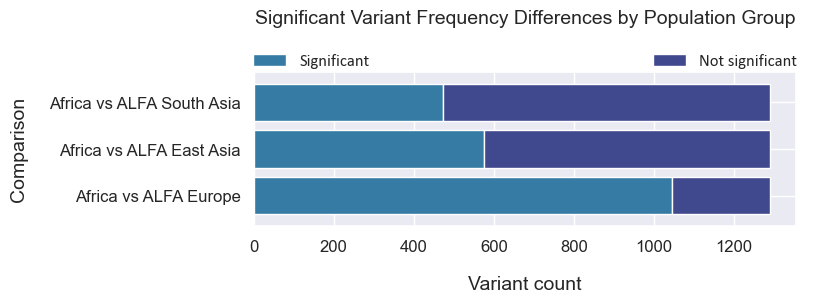

In [35]:
Significant_freq_differences[["Significant", "Not significant"]].plot(kind= "barh", stacked=True, width = 0.8, color = ["#357BA3", "#40498E"])
plt.xticks(rotation=0)
plt.xlabel('Variant count', labelpad=15)
plt.ylabel('Comparison', labelpad=15)
legend = plt.legend(loc='center',
       frameon=False,
       bbox_to_anchor=(0., 1.02, 1., .102), 
       mode='expand', 
       ncol=2, 
       borderaxespad=-.46,
       prop={'size': 12, 'family':'Calibri'})

plt.title("Significant Variant Frequency Differences by Population Group", size=constants.BIGGER_FONT, pad=35, loc="center")

plt.savefig("..\Results\Figures\Significant_freq_differences_Afr_vs_global.png", dpi=600, bbox_inches = "tight")
plt.show()